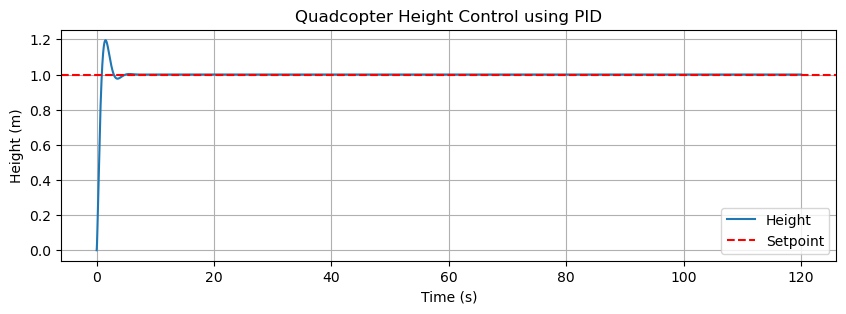

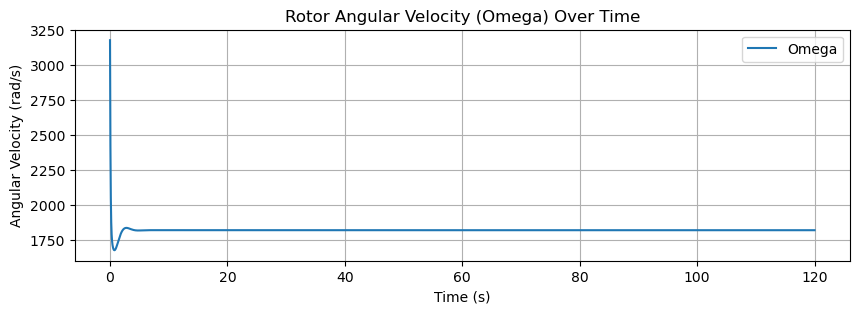

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
mass = .6783  # kg
g = 9.81  # m/s^2 (gravity)
k = 5.02*1e-7  # thrust coefficient
Kp = 20  # proportional gain
Ki = 30   # integral gain
Kd = 10  # derivative gain

# PID Controller parameters
dt = 0.01  # time step
t_max = 120  # max simulation time
setpoint = 1  # desired height (m)

# Initial conditions
height = 0  # initial height (m)
velocity = 0  # initial velocity (m/s)
integral_error = 0  # initial integral of error
previous_error = setpoint - height

# Simulation data storage
time = [0]
heights = [height]
omegas = []  # for tracking omega

# Simulation loop
for t in np.arange(dt, t_max, dt):
    error = setpoint - height
    integral_error += error * dt
    derivative_error = (error - previous_error) / dt

    # PID controller output for net thrust
    net_thrust = Kp * error + Ki * integral_error + Kd * derivative_error

    # Calculate total thrust
    thrust_per_rotor = net_thrust / 4
    if thrust_per_rotor < 0:
        thrust_per_rotor = 0  # no negative thrust
    omega = np.sqrt(thrust_per_rotor / k)

    # Calculate acceleration
    total_thrust = 4 * k * omega**2
    acceleration = (total_thrust / mass) - g

    # Update state
    velocity += acceleration * dt
    height += velocity * dt

    # Store results
    time.append(t)
    heights.append(height)
    omegas.append(omega)

    previous_error = error

# Plot the height over time
plt.figure(figsize=(10, 3))
plt.plot(time, heights, label="Height")
plt.axhline(y=setpoint, color='r', linestyle='--', label="Setpoint")
plt.title("Quadcopter Height Control using PID")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.legend()
plt.grid()
plt.show()

# Plot omega over time
plt.figure(figsize=(10, 3))
plt.plot(time[:-1], omegas, label="Omega")
plt.title("Rotor Angular Velocity (Omega) Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.legend()
plt.grid()
plt.show()


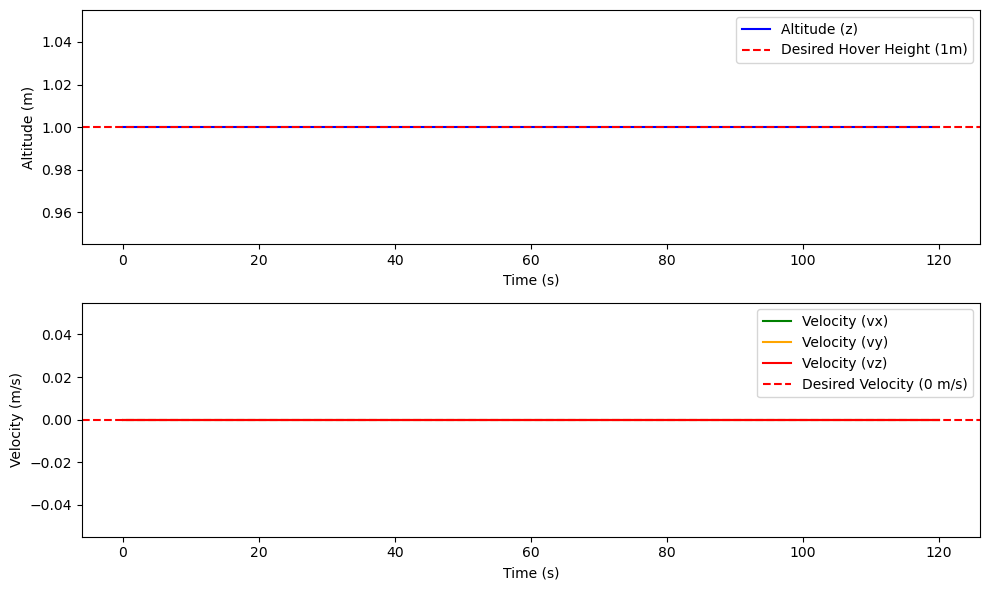

Required motor speed (for each motor) to maintain hover: 1832.42 rad/s


In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants (adjust these as needed)
m = .6873  # mass of the quadcopter (kg)
g = 9.81  # gravitational acceleration (m/s^2)
Ixx = 0.1  # Moment of inertia around x-axis (kg*m^2)
Iyy = 0.1  # Moment of inertia around y-axis (kg*m^2)
Izz = 0.1  # Moment of inertia around z-axis (kg*m^2)
K = 5.02*1e-7  # thrust coefficient (N per motor speed squared)
l = 0.1225  # arm length (m)
b = 5.02*1e-8  # drag coefficient
A_x = 0.1  # drag coefficient along x-axis
A_y = 0.1  # drag coefficient along y-axis
A_z = 0.1  # drag coefficient along z-axis


# Calculate the motor speed required for hover to generate total thrust equal to m*g
def calculate_hover_omega(mass, g, K):
    # Total thrust required to counteract gravity
    required_thrust = mass * g
    # The thrust generated by each motor is proportional to the square of its speed
    omega_hover = np.sqrt(required_thrust / (4 * K))
    return omega_hover

# Use the calculated omega_hover for all motors in hover
omega_hover = calculate_hover_omega(m, g, K)
omega1 = omega2 = omega3 = omega4 = omega_hover  # Set all motor speeds for hover

# Define the system of differential equations for hover
def eom(t, state, params):
    # Unpack the state variables
    x, y, z, vx, vy, vz, phi, theta, psi, phidot, thetadot, psidot = state
    
    # Unpack parameters
    m, Ixx, Iyy, Izz, K, l, b, A_x, A_y, A_z, omega1, omega2, omega3, omega4, g = params
    
    # Total thrust term (sum of squared angular velocities)
    total_thrust = omega1**2 + omega2**2 + omega3**2 + omega4**2
    
    # Translational accelerations
    ax = A_x * vx - K * (np.sin(phi)*np.sin(psi) + np.sin(theta)*np.cos(phi)*np.cos(psi)) * total_thrust
    ay = A_y * vy - K * (-np.sin(phi)*np.cos(psi) + np.sin(psi)*np.sin(theta)*np.cos(phi)) * total_thrust
    az = A_z * vz - K * np.cos(phi)*np.cos(theta) * total_thrust + m * g
    
    # Rotational accelerations
    phiddot = (-Ixx * phidot * np.sin(theta) - Ixx * psidot * np.dot(np.sin(theta), np.cos(theta)) 
               - 0.5 * Iyy * psidot * np.sin(phi) * np.cos(theta) + K * l * (-omega2**2 + omega4**2))
    
    thetaddot = (Ixx * psidot * (phidot - psidot * np.sin(theta)) * np.cos(theta) + Iyy * psidot 
                 * (phidot * np.sin(theta) + thetadot * np.cos(theta)) + Izz * psidot 
                 * (phidot * np.cos(theta) - thetadot * np.sin(theta)) + K * l * (-omega1**2 + omega3**2))
    
    psiddot = 0  # Assuming no angular acceleration around psi
    
    # Return the derivatives of the state variables
    return [
        vx,  # dx/dt
        vy,  # dy/dt
        vz,  # dz/dt
        ax,  # dvx/dt
        ay,  # dvy/dt
        az,  # dvz/dt
        phidot,  # dphi/dt
        thetadot,  # dtheta/dt
        psidot,  # dpsi/dt
        phiddot,  # dphidot/dt
        thetaddot,  # dthetadot/dt
        psiddot   # dpsidot/dt
    ]

# Initial conditions for hover (position at 1m, no initial velocity, no initial rotation)
initial_conditions = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Parameters for the system
params = [m, Ixx, Iyy, Izz, K, l, b, A_x, A_y, A_z, omega1, omega2, omega3, omega4, g]

# Time span for the simulation (2 minutes for hover)
t_span = (0, 120)  # 2 minutes in seconds
t_eval = np.linspace(0, 120, 1000)  # Evaluate the solution at 1000 points

# Solve the ODE for hover
sol = solve_ivp(eom, t_span, initial_conditions, args=(params,), t_eval=t_eval)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the altitude (z) over time
plt.subplot(2, 1, 1)
plt.plot(sol.t, sol.y[2], label="Altitude (z)", color="blue")
plt.axhline(y=1.0, color='r', linestyle='--', label="Desired Hover Height (1m)")
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()

# Plot the velocities (vx, vy, vz) over time
plt.subplot(2, 1, 2)
plt.plot(sol.t, sol.y[3], label="Velocity (vx)", color="green")
plt.plot(sol.t, sol.y[4], label="Velocity (vy)", color="orange")
plt.plot(sol.t, sol.y[5], label="Velocity (vz)", color="red")
plt.axhline(y=0.0, color='r', linestyle='--', label="Desired Velocity (0 m/s)")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.tight_layout()
plt.show()

# Print out the required motor speeds to maintain hover
print(f"Required motor speed (for each motor) to maintain hover: {omega_hover:.2f} rad/s")